# ICDSS Application: Real Estate Price Prediction

## Christian Deverall (3rd Year EIE)

### Project Goal:

My analysis allows real estate agents from Ames to estimate house prices using features that could only be only be obtained by viewing the house from Google Maps (both street and satelite view). This would allow real estate agents to create rough price estimations from their office.


#### Findings:

Using the confined set of features, my final model predicted price with a mean absolute percentage error of 15.1%.

#### Format:

Assumptions, reasoning and explanations are written next to the code below.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter

In [2]:
df = pd.read_csv("data.csv")

Find columns that have more than 2000 null values:

In [3]:
for i in list(df.columns):
    if len(df[i].dropna())<930:
        print(i, "- number of non-empty cols: ", len(df[i].dropna()))

Alley - number of non-empty cols:  198
PoolQC - number of non-empty cols:  13
Fence - number of non-empty cols:  572
MiscFeature - number of non-empty cols:  106


In [4]:
df.drop(["Alley","PoolQC","Fence","MiscFeature","MiscVal"], axis = 1, inplace = True)

Initial visualisation to remove anomalies. Also GrLivArea seemed to have the strongest correlation on SalePrice.

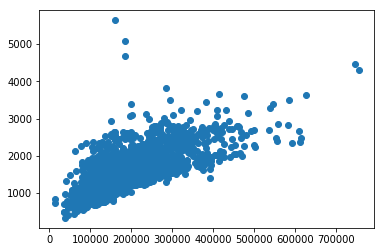

In [5]:
from matplotlib.pyplot import scatter
scatter(df["SalePrice"], df["GrLivArea"])

Drop three outliers around 150000,5000

In [6]:
df.drop(df[(df["GrLivArea"]>4000) & (df["SalePrice"]<300000)].index, inplace=True)

Features observable from Google Maps such as LotArea, Neighbourhood are kept, while non-visible features such as utilities/heating are dropped. 
#### Assumptions:
-Google Maps available for selected house and satelite/ street view not covered by trees

-Viewers can perfectly estimate continuous values such as area of the house

In [7]:
df=df[["MSZoning","LotFrontage","LotArea","Street","LotShape","LandContour","LotConfig","LandSlope","Neighborhood","Condition1","Condition2","BldgType","HouseStyle","Exterior1st","Exterior2nd","MasVnrType","MasVnrArea","ExterQual","ExterCond","BsmtExposure","1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","TotRmsAbvGrd","GarageType","GarageArea","PavedDrive","WoodDeckSF","OpenPorchSF","MoSold","YrSold","SalePrice"]]


Locate and fill columns with a few nulls:

In [8]:
for i in list(df.columns):
    if df[i].isna().value_counts()[0] !=2927:
        print (i)

LotFrontage
MasVnrType
MasVnrArea
BsmtExposure
GarageType
GarageArea


In [9]:
df["LotFrontage"].fillna(df["LotFrontage"].mean(),inplace=True)
df["MasVnrArea"].fillna(0.0,inplace=True)
df["MasVnrType"].fillna("None",inplace=True)
df["BsmtExposure"].fillna("No",inplace =True)
# ^ BsmtExposure changed to "No" because having no basement implies having no basement exposure

df["GarageType"].fillna("None",inplace=True)
df["GarageArea"].fillna(df["GarageArea"].mean(),inplace=True)

Locating ordinal values and mapping them to numerical values representing intensity:

In [10]:
for i in df.columns:
    if type(df[i][0])==str:
        print (i)

MSZoning
Street
LotShape
LandContour
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
BsmtExposure
GarageType
PavedDrive


In [11]:
df["LotShape"].replace(to_replace=["Reg","IR1","IR2","IR3"], value=[1,2,3,4], inplace =True)
df["Street"].replace(to_replace=["Grvl","Pave"], value=[1,2], inplace =True)
df["LandContour"].replace(to_replace=["Lvl","Bnk","HLS","Low"],value=[1,2,3,4],inplace =True)
df["LandSlope"].replace(to_replace=["Gtl","Mod","Sev"],value=[1,2,3],inplace =True)
df["ExterQual"].replace(to_replace=["Ex","Gd","TA","Fa","Po"],value=[1,2,3,4,5],inplace =True)
df["ExterCond"].replace(to_replace=["Ex","Gd","TA","Fa","Po"],value=[1,2,3,4,5],inplace =True)
df["BsmtExposure"].replace(to_replace=["Gd","Av","Mn","No"],value=[1,2,3,4],inplace =True)
df["PavedDrive"].replace(to_replace=["Y","P","N"],value=[1,2,3],inplace =True)

Mapping nominal variables to numbers using arbitrary label encoders


In [12]:
from sklearn import preprocessing
df[["MSZoning", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "HouseStyle", "HouseStyle", "Exterior1st", "Exterior2nd", "MasVnrType", "GarageType"]] = df[["MSZoning", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "HouseStyle", "HouseStyle", "Exterior1st", "Exterior2nd", "MasVnrType", "GarageType"]].apply(preprocessing.LabelEncoder().fit_transform)
 

Perform random train/test/validation split with ratio 60/20/20. 
Normalise continuous values that are high to have standard values:

In [13]:
X = df.drop(columns=["SalePrice"])
Y = df["SalePrice"]

rand_array = np.random.rand(len(df))
train_X_df = X[rand_array<0.6]
train_Y_df = Y[rand_array<0.6]

valid_X_df = X[(rand_array>=0.6) & (rand_array<0.8)]
valid_Y_df = Y[(rand_array>=0.6) & (rand_array<0.8)]

test_X_df = X[rand_array>=0.8]
test_Y_df = Y[rand_array>=0.8]

#### Decision:

I did not normalise continuous values as:

    1) There are no columns with a mean of values in the order of magnitude of 100,000s or more
    
    2) Every train/test/valid split of the data had very different extremities for min/max values
        - The data was being transformed by MinMaxScaler in very different ways within each data split
    
    3) When I implmented normalisation (as below), there was an increase in percentage error (MAPE) of 1.6%

In [14]:
# my_scaler = preprocessing.MinMaxScaler()
# train_X_df[["LotFrontage","LotArea","MasVnrArea","1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","OpenPorchSF"]] = my_scaler.fit_transform(train_X_df[["LotFrontage","LotArea","MasVnrArea","1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","OpenPorchSF"]])

# my_scaler.fit(valid_X_df[["LotFrontage","LotArea","MasVnrArea","1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","OpenPorchSF"]])
# valid_X_df[["LotFrontage","LotArea","MasVnrArea","1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","OpenPorchSF"]] = my_scaler.transform(valid_X_df[["LotFrontage","LotArea","MasVnrArea","1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","OpenPorchSF"]])

# my_scaler.fit(test_X_df[["LotFrontage","LotArea","MasVnrArea","1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","OpenPorchSF"]])
# test_X_df[["LotFrontage","LotArea","MasVnrArea","1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","OpenPorchSF"]] = my_scaler.transform(test_X_df[["LotFrontage","LotArea","MasVnrArea","1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","OpenPorchSF"]])

Initial data visualisations suggested that most correlations followed linear regression. A small number of columns exhibited polynomial relations.

To test what degree of polynomial to use, iterate the degree from 1 to 4. Choose the model that yields the lowest error on the cross-val set.

In [15]:
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression


train_predictions_list=[]
valid_predictions_list=[]
for i in range(1,5):
    poly = PolynomialFeatures(degree=i)
    X_poly = poly.fit_transform(train_X_df)
    pol_reg = LinearRegression()
    pol_reg.fit(X_poly, train_Y_df)
    
    train_predictions = pol_reg.predict(poly.fit_transform(train_X_df))
    train_predictions_list.append(train_predictions)
    
    valid_predictions = pol_reg.predict(poly.fit_transform(valid_X_df))
    valid_predictions_list.append(valid_predictions)

^ the point of predicting output values on the training input values is to check for overfitting later.

In [22]:
max_pred_valid =[]
for i in valid_predictions_list:
    max_pred_valid.append(((i-valid_Y_df)**2).mean())
print(math.sqrt(min(max_pred_valid)))
print("optimal degree:",np.argmin(max_pred_valid)+1)

33078.9664444894
optimal degree: 1


In [23]:
max_pred_train =[]
for i in train_predictions_list:
    max_pred_train.append(((i-train_Y_df)**2).mean())
print(math.sqrt(min(max_pred_train)))
print("optimal degree:", np.argmin(max_pred_train)+1)

275.97462133339536
optimal degree: 4


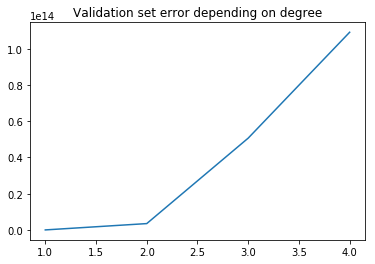

In [18]:
plt.title("Validation set error depending on degree")
plt.plot([1,2,3,4],max_pred_valid) 
plt.show()

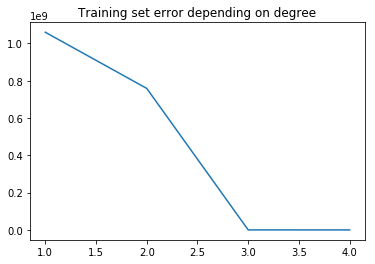

In [19]:
plt.title("Training set error depending on degree")
plt.plot([1,2,3,4],max_pred_train)
plt.show()

** ^This suggests overfitting as degree increases. Training set error goes down, while validation error goes up. **

So when degree = 1 (therefore model is linear regression), validation error is lowest. Now evaluate test set.

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(train_X_df, train_Y_df)

test_predictions = lin_reg.predict(test_X_df)

In [21]:
from sklearn.metrics import r2_score
print("Mean Absolute Percentage Error (MAPE) =",(abs(test_predictions-test_Y_df)/test_Y_df).mean()*100)
print("r2score =",r2_score(test_predictions,test_Y_df))

Mean Absolute Percentage Error (MAPE) = 15.082790560608869
r2score = 0.7595173273395691


### Thank you for reading.
##### By Christian Deverall